# 1. Importar librerias y leer el archivo houses_for_sale

In [13]:
#importar las librerias
import pandas as pd
import numpy as np 
from functools import reduce
import re

In [14]:
#leer el archivo
houses_for_sale = pd.read_csv(r"..\Datasets originales\Dataset_houses_for_sale.csv")
#revisar su forma
houses_for_sale.shape

(11269, 28)

# 2.Limpieza del dataset

### Eliminar columnas

In [15]:
#columnas para eliminar con datos que no son relevantes
columns_to_drop=['source','permalink','other_listings','open_houses','branding','coming_soon_date','matterport','search_promotions',
                 'rent_to_own','products','virtual_tours','community','price_reduced_amount','last_update_date','lead_attributes', 'tax_record']


#en la columna source hay datos de los agentes de venta, en permalink vemos el las ciudades y estados que son datos que ya esta en las columnas
#en other_listings vemos si la casa ya se ha vendido con anterioridad y open_houses se refiere a si la casa esta abierta a visitas, pero en la 
#columna esta vacia, branding es una columna de la compañia que ofrece la propiedad,coming_soon_date es una columna con nan,  matterport es una
#forma de capturar imagenes en 3d,  search_promotions busca las promociones esta llena de valores nan, rent_to_own tiene valores nan, products
#se refiere a la propiedad como producto, virtual_tours si se cuenta con link a un tour virtual, community tiene todos sus valores nan,
# price_reduced_amount son los descuentos en los precios pero tambien  las columnas estan en nan, last_update_date es la fecha en que se actualizo
#la propiedad en la pagina web,lead_attributes son caracteristicas que son importantes para la web,tax_record es el registro de trinutos

#eliminar las columas
houses_for_sale.drop(columns=columns_to_drop,inplace=True)

### Buscar filas duplicadas en la columna "description"

In [16]:
#en la columna description se ven diferentes datos importantes, como el numero de baños, tamaño en pies,etc.
#buscar en la columna description por valores que esten duplicados
#los valores duplicados estan en forma de fila, una detras de otra

#crear una lista para guardas las filas que estan duplicadas

descriptions = []
#crear lita de id que estan repetidoas
ids=[]
for index, row in houses_for_sale.groupby('property_id')['description'].apply(list).reset_index().iterrows():
    id=str(row['property_id'])
    
    if len(row['description']) > 1:

        descriptions.append(row['description'])
        ids.append(id)
        if len(ids) >2:
            break


In [17]:
#los id_producto que estan con filas duplicadas
ids

#ver que filas son las duplicadas
descriptions[0]


print("las ids duplicadas son", ids)
print("las filas duplicadas son",descriptions[0])

las ids duplicadas son ['1034050928', '1117136034', '1156155585']
las filas duplicadas son ["{'sqft': 2963, 'baths_consolidated': '3', 'lot_sqft': 12876, 'sold_price': 66045, 'baths_3qtr': None, 'baths_full': 3, 'name': None, 'sold_date': '1978-11-07', 'sub_type': None, 'year_built': 1979, 'garage': 2, 'baths_half': None, 'baths': 3, 'baths_1qtr': None, 'stories': 1, 'beds': 4, 'type': 'single_family'}", "{'sqft': 2963, 'baths_consolidated': '3', 'lot_sqft': 12876, 'sold_price': 66045, 'baths_3qtr': None, 'baths_full': 3, 'name': None, 'sold_date': '1978-11-07', 'sub_type': None, 'year_built': 1979, 'garage': 2, 'baths_half': None, 'baths': 3, 'baths_1qtr': None, 'stories': 1, 'beds': 4, 'type': 'single_family'}"]


In [18]:
#ver que filas son duplicadas por id, son exactamente las mimas filas, estan duplicadas una detras de otra
# por eso hay que eliminar
houses_for_sale[houses_for_sale['property_id']== 1034050928]

,primary_photo,tags,list_date,description,photos,flags,list_price,property_id,location,listing_id,primary,status
276,{'href': 'https://ap.rdcpix.com/e578888ca31258...,"['community_outdoor_space', 'den_or_office', '...",2023-09-28T17:12:07Z,"{'sqft': 2963, 'baths_consolidated': '3', 'lot...",[{'href': 'https://ap.rdcpix.com/e578888ca3125...,"{'is_new_construction': None, 'is_subdivision'...",925000.0,1034050928,"{'address': {'postal_code': '85254', 'state': ...",2.960065e+09,True,for_sale
472,{'href': 'https://ap.rdcpix.com/e578888ca31258...,"['community_outdoor_space', 'den_or_office', '...",2023-09-28T17:12:07Z,"{'sqft': 2963, 'baths_consolidated': '3', 'lot...",[{'href': 'https://ap.rdcpix.com/e578888ca3125...,"{'is_new_construction': None, 'is_subdivision'...",925000.0,1034050928,"{'address': {'postal_code': '85254', 'state': ...",2.960065e+09,True,for_sale


In [19]:
#eliminar las columnas duplicadas
houses_for_sale.drop_duplicates(subset='property_id', inplace = True)
print("el tamaño del dataset es :",houses_for_sale.shape)



el tamaño del dataset es : (11234, 12)


### Funcion para columnas anidadas

In [20]:
#columnas para desanidar
['primary_photo','source', 'tags', 'description','photos','flags','location']
#son columnas que esta anidadas, primary foto tien un url de las fotos, los flags son caraacteriticas de la construccion, los tags siven para 
# clasificar las propiedades, en  description estan algunas caracteristicas de las propiedades, photos tiene dos link de fotos de las prpiedades, 
#flags son caracteristicas de la construccion, y location contiene longitud, latitud, zipcode,etc.
#son importantes, 


['primary_photo',
 'source',
 'tags',
 'description',
 'photos',
 'flags',
 'location']

In [21]:
#definir una funcion para sacar los datos de las columnas que contiene cadenas que representan diccionarios

def data_processor(df, columnas, columna_target):
    
    # Inicializa una lista vacía llamada 'lista_dics_datos' para almacenar los datos transformados.
    lista_dics_datos = []
    
    # Itera a través de las filas del DataFrame 'df'.
    for _, row in df.iterrows():
        
        # Extrae el 'property_id' pues es unico en el dataframe de la fila actual.
        property_id = row['property_id']
            
        # Itera a través de los elementos en la columna especificada por 'columna_target'.
        for elemento in row[columna_target]:

            if elemento is not None:
                try:
                    # Crea un nuevo diccionario 'elemento_data' que contiene la información de la fila actual.
                    elemento_data = eval(elemento).copy()
                except:
                    elemento_data = elemento.copy()
            else:
                elemento_data = {}
                
            # Agrega información adicional al diccionario 'elemento_data'.
            elemento_data['property_id'] = property_id       
                       
            # Agrega el diccionario 'review_data' a la lista 'listadatos'.
            lista_dics_datos.append(elemento_data)

    # Crea un nuevo DataFrame 'df_limpio' a partir de la lista 'lista_dics_datos'
    # utilizando las columnas especificadas en 'columnas'.
    df_limpio = pd.DataFrame(lista_dics_datos, columns=columnas)
    
    # Devuelve el nuevo DataFrame 'df_limpio'.
    return df_limpio


### Aplicar la funcion en la columna "description"

In [ ]:
#separar la columna description para poder transformarla
df = houses_for_sale.groupby('property_id')['description'].apply(list).reset_index()

#definir una lista de columnas
columns = ['property_id']

#añadir las columnas que estan dentro de description a la base de datos como columnas
columns +=[x for x in eval(df['description'][0][0]).keys()]

#aplicar la funcion de desanidar 
df_temporal = data_processor(df,columns,'description')

#unir los datasets
df_final = pd.merge(df_temporal,houses_for_sale, on='property_id')

#eliminar la columna description pues ya se desanido
dropeable_columns = [ 'description']
df_final.drop(columns=dropeable_columns, inplace = True)

df_final.head()

### Limpiar columnas "dates"

In [23]:
#las fechas tienen un formato diferente que hay que cambiar, extraer solo los numeros de la fecha, se va a modificar
#todas las columnas que tengan fechas

#funcion para convretir las fechas a datetime 
def convert_date(text):
    try:
        return pd.to_datetime(text, errors='raise')
    except ValueError:
        return np.nan

In [24]:
#aplicar la funciona a la columna sold_date
df_final['sold_date']=df_final['sold_date'].apply(convert_date)

#imprimir las columnas que son unicas
print(len(df_final['sold_date'].unique()))

#usar los datos de esta base de datos para entrenar el otro modelo de casas vendidas
df_final[df_final['sold_date'].notna()].to_csv('Df_sold_homes_to_train.csv')

4177


In [25]:
#eliminar las columnas que ya no se usaran 
columns_to_drop = ['sold_date', 'sold_price', 'name','sub_type']
df_final.drop(columns=columns_to_drop, inplace= True)

In [26]:
#Quitar las letras de la fecha en list_date
df_final['list_date']=(df_final['list_date'].astype(str).str.split('T')).str[0]

#convertir list_date eb datetime
df_final['list_date'] = df_final['list_date'].apply(convert_date)

### Desanidar columnas 'flags','location'

In [27]:
#la columna flags tiene caracteristicas de la construccion, si tiene diviones, si es nueva la construccion, si tiene planos
#la columna location tiene informacion como estado, coordenadas,ciudad
#mostar las columnas que son str
for column in df_final.columns:
    if type(df_final[column][2]) is str:
        print( column , df_final[column][2]+'\n')

baths_consolidated 3.5

type single_family

primary_photo {'href': 'https://ap.rdcpix.com/fd492f6878f09cbe6eda231a8fcceb73l-m763238679s-w1024_h768.jpg'}

tags ['community_boat_facilities', 'community_golf', 'community_outdoor_space', 'community_security_features', 'den_or_office', 'energy_efficient', 'fireplace', 'golf_course_lot_or_frontage', 'golf_course_view', 'laundry_room', 'pets_allowed', 'recreation_facilities', 'view', 'single_story', 'garage_1_or_more', 'garage_2_or_more', 'garage_3_or_more', 'gourmet_kitchen', 'high_ceiling', 'wine_cellar', 'gated_community', 'clubhouse', 'golf_course', 'views', 'groundscare', 'security']

photos [{'href': 'https://ap.rdcpix.com/fd492f6878f09cbe6eda231a8fcceb73l-m763238679s-w1024_h768.jpg'}, {'href': 'https://ap.rdcpix.com/fd492f6878f09cbe6eda231a8fcceb73l-m3583859794s-w1024_h768.jpg'}]

flags {'is_new_construction': None, 'is_subdivision': None, 'is_plan': None, 'is_price_reduced': None, 'is_pending': None, 'is_foreclosure': None, 'is_new_li

In [28]:
#ver las columnas que tienen diccionarios por dentro
df_final[['primary_photo','tags','photos','flags','location']].head()

,primary_photo,tags,photos,flags,location
0,{'href': 'https://ap.rdcpix.com/c40746b359c3d7...,"['central_air', 'community_outdoor_space', 'di...",[{'href': 'https://ap.rdcpix.com/c40746b359c3d...,"{'is_new_construction': None, 'is_subdivision'...","{'address': {'postal_code': '94804', 'state': ..."
1,{'href': 'https://ap.rdcpix.com/7501bd1b85a32e...,"['basement', 'community_outdoor_space', 'dinin...",[{'href': 'https://ap.rdcpix.com/7501bd1b85a32...,"{'is_new_construction': None, 'is_subdivision'...","{'address': {'postal_code': '98208', 'state': ..."
2,{'href': 'https://ap.rdcpix.com/fd492f6878f09c...,"['community_boat_facilities', 'community_golf'...",[{'href': 'https://ap.rdcpix.com/fd492f6878f09...,"{'is_new_construction': None, 'is_subdivision'...","{'address': {'postal_code': '85383', 'state': ..."
3,{'href': 'https://ap.rdcpix.com/0487398867f4fd...,"['central_air', 'central_heat', 'city_view', '...",[{'href': 'https://ap.rdcpix.com/0487398867f4f...,"{'is_new_construction': None, 'is_subdivision'...","{'address': {'postal_code': '92591', 'state': ..."
4,{'href': 'https://ap.rdcpix.com/8926b1a848f534...,"['community_outdoor_space', 'den_or_office', '...",[{'href': 'https://ap.rdcpix.com/8926b1a848f53...,"{'is_new_construction': None, 'is_subdivision'...","{'address': {'postal_code': '94602', 'state': ..."


In [29]:

def unraveler(df, target_columns:list):
    #crear una lista vacia para almacenar los datasets
    dfs_temporales =[]
    
    #iterar sobre las columnas de target_columns
    for column in target_columns:
        
        #crear un dataset con agrupado por property id pero de acuerdo a cada columna de la lista de columnas
        df_grouped = df.groupby('property_id')[column].apply(list).reset_index()
        
        #crear una lista de nombres de columnas
        columns = ['property_id']
        
        #aumentar en cada lista los valores que estan dentro de los diccionarios anidados
        try:
            columns +=[x for x in eval(df_grouped[column][0][0]).keys()]
        except:
            columns +=[x for x in (df_grouped[column][0][0]).keys()]
        
        #aplicar la funcion para desanidar
        df_temporal = data_processor(df_grouped,columns,column)
        dfs_temporales.append(df_temporal)
    
    # combinar los dataframes en uno nuevo
    resultado = reduce(lambda left, right: pd.merge(left, right, on='property_id'), dfs_temporales)
    
    #combinar los dataframe por la columna property_id
    resultado = pd.merge(resultado,df, on='property_id')
    return resultado
    

In [30]:
#columnas a convertir
columns = ['flags','location']

#aplicar la funcion para desanidar
df_final = unraveler(df_final, columns)

#eliminar columnas nuevas que salieron de los diccionarios que se desanidaron
df_final.drop(columns=['is_new_listing','is_pending','flags','location',"is_subdivision"], inplace = True)

### Limpieza de las columnas que contengan la palabra "baths

In [31]:
# Utiliza expresiones regulares para encontrar todos los números en la cadena.
def extraer_numeros(cadena):
    
    # El patrón \d+\.\d+|\d+ busca números enteros o decimales en la cadena.
    numeros_encontrados = re.findall(r'\d+\.\d+|\d+', str(cadena))
    
    # Si se encuentran números en la cadena:
    if numeros_encontrados:
        # Une los números encontrados utilizando comas y devuelve la cadena resultante.
        return ','.join(numeros_encontrados)
    
    # Si no se encuentran números en la cadena, devuelve 0.
    return np.nan

In [32]:
#la columa de baños se debe convertir a numeros
df_final['baths_consolidated'] = df_final['baths_consolidated'].apply(extraer_numeros)

#la columa de baños se convierte en float
df_final['baths_consolidated'] = df_final['baths_consolidated'].apply(float)

In [33]:
#se va a limpiar las columnas que contengan la palabra bath

#hacer una lista
bath_columns= []
#iterar en la columna para hacer la lista
for column in df_final.columns:
    if 'bath' in column:
        bath_columns.append(column)

#iterar en la lista creada para saber cuales tienen mas datos utiles en sus columnas
for column in bath_columns:
    #buscar en el dataframe tal que la columna baths_consolidated tenga datos nan para ver si se puede rellenar los faltantes
    for num in df_final[df_final['baths_consolidated'].isna()==True][column]:
        if num > 0:
            print(num)

#no existen datos validos por lo que se van a eliminar las columnas 

In [34]:
#Eliminar de la lista la columna baths_consolidated
bath_columns.remove('baths_consolidated')

#Eliminar las columnas de que tengan bath
df_final.drop(bath_columns, axis=1, inplace=True)

#renombar la columna
df_final=df_final.rename(columns={"baths_consolidated":"baths"})

### Limpiar columnas "tags"

In [35]:
#la columna tags contiene tags que dan caracteristicas especificas de la propiedad
#ver que columnas son de tipo str
for column in df_final.columns:
    if type(df_final[column][2]) is str:
        print( f'{column}' , df_final[column][2]+'\n')

street_view_url https://maps.googleapis.com/maps/api/streetview?channel=rdc-streetview&client=gme-movesalesinc&location=31010%20N%20117th%20Dr%2C%20Peoria%2C%20AZ%2085383&size=640x480&source=outdoor&signature=UWiFqjBXrMeXn8KQlA5gWBuNatU=

type single_family

primary_photo {'href': 'https://ap.rdcpix.com/fd492f6878f09cbe6eda231a8fcceb73l-m763238679s-w1024_h768.jpg'}

tags ['community_boat_facilities', 'community_golf', 'community_outdoor_space', 'community_security_features', 'den_or_office', 'energy_efficient', 'fireplace', 'golf_course_lot_or_frontage', 'golf_course_view', 'laundry_room', 'pets_allowed', 'recreation_facilities', 'view', 'single_story', 'garage_1_or_more', 'garage_2_or_more', 'garage_3_or_more', 'gourmet_kitchen', 'high_ceiling', 'wine_cellar', 'gated_community', 'clubhouse', 'golf_course', 'views', 'groundscare', 'security']

photos [{'href': 'https://ap.rdcpix.com/fd492f6878f09cbe6eda231a8fcceb73l-m763238679s-w1024_h768.jpg'}, {'href': 'https://ap.rdcpix.com/fd492f68

In [36]:
##funcion para evaluar los nan en la columna tags
def safe_eval(expression):
    try:
        result = eval(expression)
        return result
    except Exception as e:

        if expression is np.nan:
            return expression
        else:
            
            print(f"Error en la evaluación: {e}, and was given {expression}")
            return expression


In [37]:
#se aplica la funcion a la columna tags
df_final['tags'] = df_final['tags'].apply(safe_eval)

In [38]:
#poner en lista cada una de las filas de la columna tags
def get_tags(list):
    
    my_list = []
    try:
        for tag in list:
            my_list.append(tag)
        return my_list 
    except:
        return my_list

In [39]:
#Aplicar la funciona a cada fila de la columna tags
tags = []
#recorre cada fila del datafram para sacar los tags
for index, row in df_final.iterrows():
    
    tag=get_tags(row['tags'])

    tags+=tag

In [40]:
#imprimir los resultados
print("el total de tags es:",len(tags))
print("los tags unicos son:",len(set(tags)))

el total de tags es: 127814
los tags unicos son: 168


### Definir los tags mas vendidos

In [41]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

#se va a hacer un wordcloud para saber cuales son los tags mas usados
# Tu lista de palabras
lista_de_palabras = tags
# Convierte la lista en una cadena de texto
texto = " ".join(lista_de_palabras)


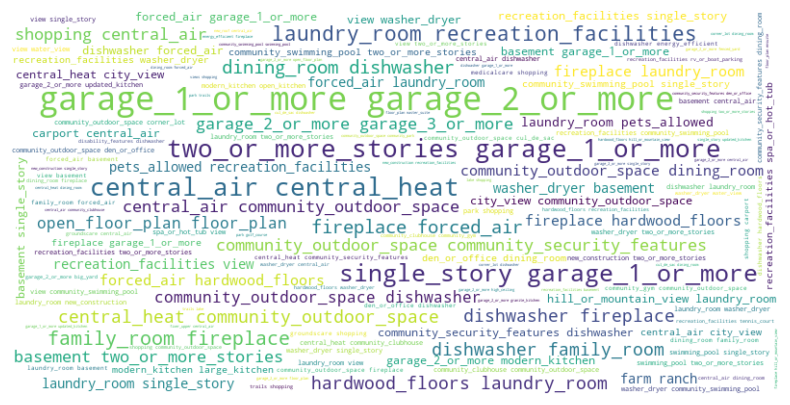

In [42]:
# Crea un objeto WordCloud
nube_de_palabras = WordCloud(width=800, height=400, background_color='white').generate(texto)

# Muestra la nube de palabras utilizando Matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(nube_de_palabras, interpolation='bilinear')
plt.axis("off")
plt.show()


In [43]:
#para eliminar las tags que son las mas frecuentes 
Start_tags=0
current_tags=1
while Start_tags != current_tags:
    Start_tags=len(tags)
    for tag in tags:
        #eliminar las palabras garage y story pues ya son parte del dataframe
        if 'garage' in tag or 'story' in tag or 'stories' in tag:
            tags.remove(tag)
    current_tags=len(tags)

In [44]:
#definir los tags unicos que hay en tags
tags_unicos ={}
#recorrer los tags para sacar un diccionario con los nombres y cantidad de tags
for tag in tags:
    if tag not in tags_unicos.keys():
        tags_unicos[tag]=tags.count(tag)
    else:
        tags.remove(tag)

#poner el resultado del diccionario en un dataframe
top_50_tags = pd.DataFrame(tags_unicos.values(),tags_unicos.keys()).sort_values(by=0,ascending=False).head(50).rename(columns={0:'count'})

### Desanidar las columnas 'address',"county","photos" 

In [ ]:
#la columna address tiene informacion de la localizacion de la propiedad
#la columna country tiene informacion que usa el estado para localizar las propiedades
#la columna photos tiene dos url de fotos de la propiedad

#columnas a convertir
columns = ['address',"county"]

#aplicar la funcion para desanidar
df_final = unraveler(df_final, columns)

#aplicar a la columna que se desanido a partir de adress
df_final = unraveler(df_final,['coordinate'])

#eliminar las columnas que ya se trabajaron
df_final.drop(columns=['coordinate','county','address'], inplace=True)

In [ ]:
#aplicar la funcion safe eval para preparar la columna photos para desanidarla
df_final['photos'] = df_final['photos'].apply(safe_eval)

#funcion para obtener de la columna photos el segundo link de la foto, le primero ya se tiene en la columna photo
def get_second_photo(list):
    try:
        #toma el segundo link de foto
        list=list[1]
        #toma el link sin la palabra href previo al url
        list=list['href']
        return list
        #sino encuentra un segundo link, toma el primero
    except:
        try:
            list=list[0]
            list = list['href']
            return list 
        except:
            
            return list

#aplicar la funcion para sacar la segunda foto    
df_final['photos'] = df_final['photos'].apply(get_second_photo)

In [ ]:
df_final.head()

,property_id,lon,lat,postal_code,state,city,state_code,line,fips_code,name,...,beds,type,primary_photo,tags,list_date,photos,list_price,listing_id,primary,status
0,1000163193,-122.340542,37.948990,94804,California,Richmond,CA,2814 Lowell Ave,06013,Contra Costa,...,2.0,single_family,{'href': 'https://ap.rdcpix.com/c40746b359c3d7...,"[central_air, community_outdoor_space, dishwas...",2023-09-16,https://ap.rdcpix.com/c40746b359c3d70b1696f82f...,899000.0,2.959741e+09,True,for_sale
1,1000748625,-122.196956,47.918020,98208,Washington,Everett,WA,8729 Del Campo Dr,53061,Snohomish,...,4.0,single_family,{'href': 'https://ap.rdcpix.com/7501bd1b85a32e...,"[basement, community_outdoor_space, dining_roo...",2023-09-27,https://ap.rdcpix.com/7501bd1b85a32ead25dd46b5...,870000.0,2.960037e+09,True,for_sale
2,1001237574,-112.313678,33.763826,85383,Arizona,Peoria,AZ,31010 N 117th Dr,04013,Maricopa,...,4.0,single_family,{'href': 'https://ap.rdcpix.com/fd492f6878f09c...,"[community_boat_facilities, community_golf, co...",2023-09-27,https://ap.rdcpix.com/fd492f6878f09cbe6eda231a...,1899000.0,2.960018e+09,True,for_sale
3,1001483948,-117.133291,33.540322,92591,California,Temecula,CA,39920 N General Kearny Rd,06065,Riverside,...,4.0,single_family,{'href': 'https://ap.rdcpix.com/0487398867f4fd...,"[central_air, central_heat, city_view, den_or_...",2023-09-26,https://ap.rdcpix.com/0487398867f4fdca5c707a75...,679000.0,2.959985e+09,True,for_sale
4,1001489359,-122.206693,37.804517,94602,California,Oakland,CA,2520 Rampart St,06001,Alameda,...,2.0,single_family,{'href': 'https://ap.rdcpix.com/8926b1a848f534...,"[community_outdoor_space, den_or_office, dinin...",2023-09-26,https://ap.rdcpix.com/8926b1a848f534b30828ca98...,799000.0,2.960011e+09,True,for_sale


In [ ]:
df_final.to_csv('Houses_for_sale_processed.csv',index = False)